In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Activation, Dropout, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from lightgbm import LGBMRegressor
import optuna
from sklearn.base import clone
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')
test_ids = test['id']

In [3]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
def filling_missing_values(data):
    # Handle missing numerical values with mean
    data['Age'] = data['Age'].fillna(data['Age'].mean())
    data['Annual Income'] = data['Annual Income'].fillna(data['Annual Income'].mean())
    data['Number of Dependents'] = data['Number of Dependents'].fillna(data['Number of Dependents'].mean())
    data['Health Score'] = data['Health Score'].fillna(data['Health Score'].mean())
    data['Previous Claims'] = data['Previous Claims'].fillna(data['Previous Claims'].mean())
    data['Vehicle Age'] = data['Vehicle Age'].fillna(data['Vehicle Age'].mean())
    data['Credit Score'] = data['Credit Score'].fillna(data['Credit Score'].mean())
    data['Insurance Duration'] = data['Insurance Duration'].fillna(data['Insurance Duration'].mean())
    
    # Handle missing categorical values with mode or special category
    data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1}).fillna(-1)  # Use -1 for missing values
    data['Marital Status'] = data['Marital Status'].fillna(data['Marital Status'].mode().iloc[0])
    data['Marital Status'] = data['Marital Status'].map({'Single': 0, 'Married': 1, 'Divorced': 2}).fillna(-1)
    data['Education Level'] = data['Education Level'].map({'PhD': 0, "Master's": 1, "Bachelor's": 2, "High School": 3}).fillna(-1)
    data['Occupation'] = data['Occupation'].fillna(data['Occupation'].mode().iloc[0])
    data['Occupation'] = data['Occupation'].map({'Employed': 0, "Self-Employed": 1, "Unemployed": 2}).fillna(-1)
    data['Customer Feedback'] = data['Customer Feedback'].fillna(data['Customer Feedback'].mode().iloc[0])
    data['Customer Feedback'] = data['Customer Feedback'].map({'Good': 0, "Average": 1, "Poor": 2}).fillna(-1)
    data['Smoking Status'] = data['Smoking Status'].map({'No': 0, 'Yes': 1}).fillna(-1)
    data['Exercise Frequency'] = data['Exercise Frequency'].map({'Monthly': 0, 'Weekly': 1, 'Daily': 2, 'Rarely': 3}).fillna(-1)
    data['Property Type'] = data['Property Type'].map({'House': 0, 'Condo': 1, 'Apartment': 2}).fillna(-1)
    
    # Handle missing 'Location' and 'Policy Type'
    data['Location'] = data['Location'].map({'Suburban': 0, 'Rural': 1, 'Urban': 2}).fillna(-1)
    data['Policy Type'] = data['Policy Type'].map({'Premium': 0, 'Comprehensive': 1, 'Basic': 2}).fillna(-1)

    # Extract date features from 'Policy Start Date'
    data['Policy Start Date'] = pd.to_datetime(data['Policy Start Date'], errors='coerce')  # Handle invalid datetime
    data['policy_year'] = data['Policy Start Date'].dt.year
    data['policy_month'] = data['Policy Start Date'].dt.month
    data['policy_day'] = data['Policy Start Date'].dt.day
    data['policy_hour'] = data['Policy Start Date'].dt.hour
    data['policy_minute'] = data['Policy Start Date'].dt.minute
    data['policy_seconds'] = data['Policy Start Date'].dt.second
    data['policy_day_of_week'] = data['Policy Start Date'].dt.dayofweek
    data['policy_is_weekend'] = (data['policy_day_of_week'] >= 5).astype(int)

    # Drop original datetime column
    data.drop(columns=['Policy Start Date'], inplace=True)

    return data


In [5]:
train = filling_missing_values(train)
test = filling_missing_values(test)
X = train.drop(columns=['Premium Amount'])
Y = train['Premium Amount']

In [6]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,policy_year,policy_month,policy_day,policy_hour,policy_minute,policy_seconds,policy_day_of_week,policy_is_weekend
0,0,19.0,1,10049.0,1,1.0,2,1,22.598761,2,0,2.0,17.0,372.00000,5.0,2,0,1,0,2869.0,2023,12,23,15,21,39,5,1
1,1,39.0,1,31678.0,2,3.0,1,0,15.569731,1,1,1.0,12.0,694.00000,2.0,1,1,0,0,1483.0,2023,6,12,15,21,39,0,0
2,2,23.0,0,25602.0,2,3.0,3,1,47.177549,0,0,1.0,14.0,592.92435,3.0,0,1,1,0,567.0,2023,9,30,15,21,39,5,1
3,3,21.0,0,141855.0,1,2.0,2,0,10.938144,1,2,1.0,0.0,367.00000,1.0,2,1,2,2,765.0,2024,6,12,15,21,39,2,0
4,4,21.0,0,39651.0,0,1.0,2,1,20.376094,1,0,0.0,8.0,598.00000,4.0,2,1,1,0,2022.0,2021,12,1,15,21,39,2,0


# Neural Network Model

> I used a ResNet approach to overcome the vanishing gradient problem, but after reviewing the results, I'm not sure what went wrong. I expected this model to perform very well, but it seems to be doing the opposite. I’ve still included it in the notebook in case anyone has suggestions.

In [7]:
def model(input_shape):
    # Input layer
    X_input = tf.keras.Input(shape=input_shape)
    X_shortcut = X_input

    # Layer 1
    X = layers.Dense(units=64)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.ReLU()(X)

    # Layer 2 with Skip Connection
    X_shortcut = layers.Dense(units=64)(X_shortcut)  # Match dimensions for skip connection
    X = layers.Dense(units=64)(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Add()([X, X_shortcut])  # Adding skip connection
    X = layers.ReLU()(X)

    # Layer 3
    X = layers.Dense(units=128)(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.ReLU()(X)

    # Layer 4 with Skip Connection
    X_shortcut = layers.Dense(units=256)(X)  # Update shortcut for this block
    X = layers.Dense(units=256)(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Add()([X, X_shortcut])  # Adding skip connection
    X = layers.ReLU()(X)

    # Layer 5
    X = layers.Dense(units=256)(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.ReLU()(X)

    # Output layer
    output_layer = layers.Dense(units=1, activation=None)(X)

    # Create the model
    model = tf.keras.Model(inputs=X_input, outputs=output_layer)
    return model

In [8]:
X = train.drop('Premium Amount', axis=1).to_numpy()
Y = train['Premium Amount'].to_numpy()
test = test.to_numpy()

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
regression_model = model(input_shape=(X_train.shape[1],))
regression_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])
history =regression_model.fit(X_train, Y_train, epochs=20, batch_size=2000, validation_data=(X_val, Y_val))

Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - loss: 1911198.8750 - root_mean_squared_error: 1382.3931 - val_loss: 1724384.0000 - val_root_mean_squared_error: 1313.1581
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 1486258.6250 - root_mean_squared_error: 1218.5883 - val_loss: 1062509.1250 - val_root_mean_squared_error: 1030.7809
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 957674.1875 - root_mean_squared_error: 978.2634 - val_loss: 783923.5000 - val_root_mean_squared_error: 885.3945
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 761505.8750 - root_mean_squared_error: 872.6404 - val_loss: 749706.4375 - val_root_mean_squared_error: 865.8559
Epoch 5/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 746967.6875 - root_mean_squared_error: 864.2714 - val_loss: 746541.6250 - val_root_mean_squared_error: 864.0264
Epoch 6/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 747146.4375 - root_mean_squared_error: 864.3755 - val_loss: 

Final Training RMSE: 864.1550
Final Validation RMSE: 863.5817


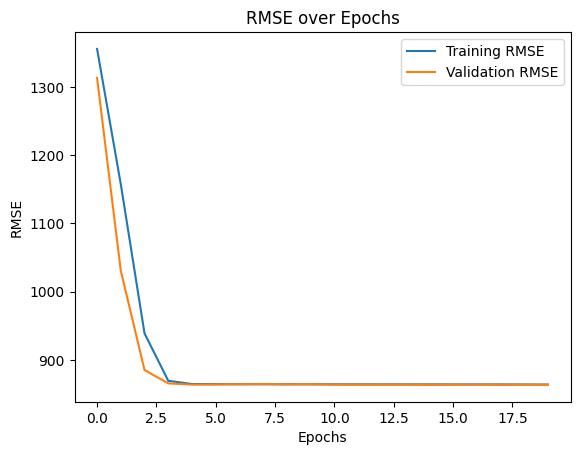

In [10]:
## Access RMSE values
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

# Print final RMSE values
print(f"Final Training RMSE: {train_rmse[-1]:.4f}")
print(f"Final Validation RMSE: {val_rmse[-1]:.4f}")

# Plot RMSE over epochs
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [11]:
# prediction = regression_model.predict(test)
# result =pd.DataFrame ({
#     'id': test_ids,
#     'Premium Amount': prediction.flatten()
# })
#
# result.to_csv('Neural_Network5.csv', index=False)
# LeaderBoard Score: 1.18595


# Using LGBMRegressor Model

In [12]:
# def objective(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5),
#         'num_leaves': trial.suggest_int('num_leaves', 150, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 25),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
#         'subsample': trial.suggest_float('subsample', 0.4, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4,1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 3),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 3),
#         # Fixed parameters
#         'objective': 'regression',
#         'metric': 'mse',
#         'boosting_type': 'gbdt',
#         'verbose': -1
#     }
#     kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#     LGB_model = LGBMRegressor(**params)

#     for train_idx, test_idx in kfold.split(X, Y):
#         X_train, X_CV = X[train_idx], X[test_idx]
#         Y_train, Y_CV = Y[train_idx], Y[test_idx]

#         Model = clone(LGB_model)
#         Model.fit(X_train, Y_train)

#         train_prediction = Model.predict(X_train)
#         train_error = np.sqrt(mean_squared_error(Y_train, train_prediction))
#         training_error.append(train_error)

#         prediction = Model.predict(X_CV)
#         error = np.sqrt(mean_squared_error(Y_CV, prediction))
#         validation_error.append(error)

#     return np.mean(validation_error)

In [13]:
# training_error = []
# validation_error = []
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)
# best_parameters = study.best_params
# print(f'Best Parameters: {best_parameters}')

# plt.plot(training_error, label='Training Error')
# plt.plot(validation_error, label='Validation Error')
# plt.title('RMSE Training vs Validation')
# plt.xlabel('Trials')
# plt.ylabel('RMSE')
# plt.show()

In [14]:
best_parameters ={
                    'learning_rate': 0.05607423932789277,
                  'num_leaves': 972,
                  'max_depth': 25,
                  'min_child_samples': 48,
                  'subsample': 0.4733368009491471,
                  'colsample_bytree': 0.4625910542149136,
                  'reg_alpha': 0.5369303802708364,
                  'reg_lambda': 1.7172300328737573
                }

In [15]:
Model = LGBMRegressor(**best_parameters, verbosity=-1)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in kfold.split(X, Y):
    X_train, X_CV = X[train_idx], X[test_idx]
    Y_train, Y_CV = Y[train_idx], Y[test_idx]

    Model.fit(X_train, Y_train)


In [16]:
pred = Model.predict(test)
result = pd.DataFrame({
    'id': test_ids,
     'Premium Amount': pred
})
result.to_csv('Predictions.csv', index=False)